In [2]:
import pandas as pd

df = pd.read_csv("../data/processed/processed_data.csv")


In [5]:
id_cols = [
    "TransactionId",
    "BatchId",
    "AccountId",
    "SubscriptionId",
    "CustomerId",
    "ProductId",
    "ProviderId"
]

df = df.drop(columns=id_cols, errors="ignore")


In [6]:
df.dtypes


CurrencyCode             object
CountryCode               int64
ProductCategory          object
ChannelId                object
Amount                  float64
Value                   float64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object

In [7]:
df.select_dtypes(include="object").columns


Index(['CurrencyCode', 'ProductCategory', 'ChannelId', 'TransactionStartTime'], dtype='object')

In [9]:
id_cols = [
    "CurrencyCode",
    "ProductCategory",
    "ChannelId",
    "TransactionStartTime",
]

df = df.drop(columns=id_cols, errors="ignore")


In [10]:
df.dtypes


CountryCode          int64
Amount             float64
Value              float64
PricingStrategy      int64
FraudResult          int64
dtype: object

In [ ]:
# Train / Test Split

from sklearn.model_selection import train_test_split

target = "FraudResult"

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Baseline Model (Logistic Regression)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print("LR AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# this is baseline model


LR AUC: 0.9978325853469878
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.46      0.33      0.39        39

    accuracy                           1.00     19133
   macro avg       0.73      0.67      0.69     19133
weighted avg       1.00      1.00      1.00     19133



In [ ]:
# Tree-Based Model (Gradient Boosting)

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

print("Gradient Boosting AUC:", roc_auc_score(y_test, y_prob_gb))
print(classification_report(y_test, y_pred_gb))

# i used WOE

Gradient Boosting AUC: 0.9864664158159497
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.81      0.87      0.84        39

    accuracy                           1.00     19133
   macro avg       0.90      0.94      0.92     19133
weighted avg       1.00      1.00      1.00     19133



In [14]:
# Model Comparison

import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Gradient Boosting"],
    "AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_gb)
    ]
})

results


,Model,AUC
0,Logistic Regression,0.997833
1,Gradient Boosting,0.986466


In [15]:
# Feature Importance / Explainability 
# Logistic Regression (Coefficients)

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lr.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(10)


,Feature,Coefficient
2,Value,1.237148
0,CountryCode,-0.023494
1,Amount,-0.311669
3,PricingStrategy,-0.509194


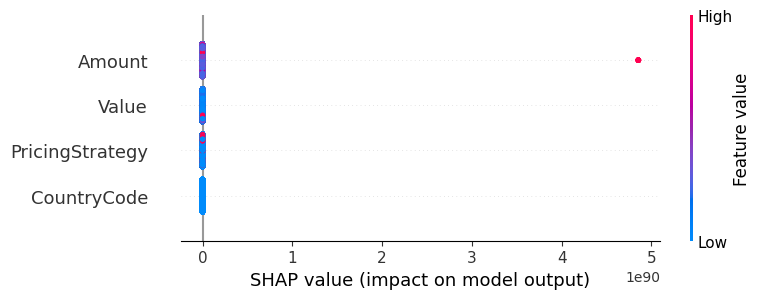

In [18]:
# SHAP for Gradient Boosting

import shap

explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test, check_additivity=False)

shap.summary_plot(shap_values, X_test)



In [20]:
# Save Models

import os
import joblib

# Create the folder if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save models
joblib.dump(lr, "../models/logistic_regression.pkl")
joblib.dump(gb, "../models/gradient_boosting.pkl")



['../models/gradient_boosting.pkl']

In [21]:
import joblib
import os

# Make sure the models folder exists
os.makedirs("../models", exist_ok=True)

# Save SHAP explainer
joblib.dump(explainer, "../models/gradient_boosting_shap_explainer.pkl")

# Later, you can load it like this
# loaded_explainer = joblib.load("../models/gradient_boosting_shap_explainer.pkl")


['../models/gradient_boosting_shap_explainer.pkl']

Best Model: Gradient Boosting – higher recall for fraud.
Key Features: Value ↑, Pricing Strategy ↓, Amount & Country Code ↓ influence fraud risk.
Reducing False Negatives: Detects more frauds but may increase false positives.
Recall vs Precision: Higher recall catches more frauds; higher precision reduces false alerts. Trade-off must balance detection vs inconvenience.

In [23]:
import sys
from pathlib import Path

# Add the src folder to the path so Python can find data_processing.py
sys.path.append(str(Path("../src").resolve()))

from data_processing import preprocess_data  # import your function


In [24]:
import pandas as pd

df = pd.read_csv("../data/raw/data.csv")  # load raw data
df = preprocess_data(df)                  # preprocess


In [25]:
import pandas as pd

df = pd.read_csv("../data/raw/data.csv")  # load raw data
df = preprocess_data(df)                  # preprocess


In [26]:
df.to_csv("../data/processed/processed_data.csv", index=False)


In [ ]:
import pandas as pd
import joblib
from data_processing import preprocess_data

# Load new transactions
data = pd.read_csv("../data/new_transactions.csv")

# Preprocess data
processed_data = preprocess_data(data)

# Load trained models
lr_model = joblib.load("../models/logistic_regression.pkl")
gb_model = joblib.load("../models/gradient_boosting.pkl")

# Make predictions
lr_pred = lr_model.predict(processed_data)
lr_prob = lr_model.predict_proba(processed_data)[:, 1]

gb_pred = gb_model.predict(processed_data)
gb_prob = gb_model.predict_proba(processed_data)[:, 1]

# Save results
results = data.copy()
results['LR_Pred'] = lr_pred
results['LR_Prob'] = lr_prob
results['GB_Pred'] = gb_pred
results['GB_Prob'] = gb_prob

results.to_csv("../data/predictions.csv", index=False)
print("Predictions saved to data/predictions.csv")
